In [1]:
# pip install --user ipykernel
# python -m ipykernel install --user --name=myenv
import csv
import tqdm
import click
import logging
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

from string import digits

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

seed = 42
epochs = 20
batch_size = 32
learning_rate = 1e-3
context_frames = 10
sequence_length = 20
lookback = sequence_length

context_epochs = 20
context_batch_size = 1
context_learning_rate = 1e-3

test_train_split = 0.9  # precentage of train data from total

torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#  use gpu if available


class BatchGenerator:
    def __init__(self, data_dir, logger):
        self.data_dir = data_dir
        data_map = []
        with open(data_dir + 'map.csv', 'r') as f:  # rb
            reader = csv.reader(f)
            for row in reader:
                data_map.append(row)

        if len(data_map) <= 1: # empty or only header
            logger.error("No file map found")
            exit()

        self.data_map = data_map

    def load_context_data(self):
        dataset_train = ContextDataSet(self.data_dir, self.data_map, train=True)
        dataset_test = ContextDataSet(self.data_dir, self.data_map, train=False)
        transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=context_batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=context_batch_size, shuffle=True)
        return train_loader, test_loader

    def load_full_data(self):
        dataset_train = FullDataSet(self.data_dir, self.data_map, train=True)
        dataset_test = FullDataSet(self.data_dir, self.data_map, train=False)
        transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
        return train_loader, test_loader


class ContextDataSet():
    def __init__(self, data_dir, data_map, train=True):
        context_file_names = []
        context_data = []
        for value in data_map[1:]:  # ignore header
            if value[8] not in context_file_names:
                context_file_names.append(value[8])
                context_data.append(np.load(data_dir + value[8]))
        if train:
            self.samples = context_data[0:int(len(context_data)*test_train_split)]
        else:
            self.samples = context_data[int(len(context_data)*test_train_split):-1]
        data_map = None

    def __len__(self):
        return len(self.samples)

    def __getitem__(self,idx):
        return(self.samples[idx])


class FullDataSet():
    def __init__(self, data_dir, data_map, train=True):
        dataset_full = []
        for value in data_map[1:]:  # ignore header
            state = np.float32(np.load(data_dir + '/' + value[4]))
            dataset_full.append([np.load(data_dir + value[8]),
                                 np.float32(np.load(data_dir + '/' + value[2])),
                                 np.float32(np.load(data_dir + '/' + value[3])),
                                 np.asarray([state[0] for i in range(0, len(state))])])
        if train:
            self.samples = dataset_full[0:int(len(dataset_full)*test_train_split)]
        else:
            self.samples = dataset_full[int(len(dataset_full)*test_train_split):-1]
        data_map = None

    def __len__(self):
        return len(self.samples)

    def __getitem__(self,idx):
        return(self.samples[idx])

data_dir = '/home/user/Robotics/Data_sets/slip_detection/vector_normalised_001/'
logger = logging.getLogger(__name__)

BG = BatchGenerator(data_dir, logger)

IndentationError: expected an indented block (<ipython-input-1-77417b0dde3c>, line 40)

In [2]:
class ContextAutoEncoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        logger = kwargs["logger"]
        logger.info("Auto Encoder Initialised")

        self.encoder_hidden1_layer = nn.Linear(in_features=kwargs["input_shape"], out_features=128)
        self.encoder_hidden2_layer = nn.Linear(in_features=128, out_features=74)
        self.encoder_output_layer = nn.Linear(in_features=74, out_features=48)

        self.decoder_hidden1_layer = nn.Linear(in_features=48, out_features=74)
        self.decoder_hidden2_layer = nn.Linear(in_features=74, out_features=128)
        self.decoder_output_layer = nn.Linear(in_features=128, out_features=kwargs["input_shape"])

    def forward(self, features):
        activation1 = self.encoder_hidden1_layer(features)
        activation1 = torch.relu(activation1)

        activation2 = self.encoder_hidden2_layer(activation1)
        activation2 = torch.relu(activation2)

        code = self.encoder_output_layer(activation2)
        code = torch.sigmoid(code)

        activation1 = self.decoder_hidden1_layer(code)
        activation1 = torch.relu(activation1)

        activation2 = self.decoder_hidden2_layer(activation1)
        activation2 = torch.relu(activation2)

        activation3 = self.decoder_output_layer(activation2)
        reconstructed = torch.sigmoid(activation3)

        return reconstructed

    def encoder(self, features):
        activation1 = self.encoder_hidden1_layer(features)
        activation1 = torch.relu(activation1)

        activation2 = self.encoder_hidden2_layer(activation1)
        activation2 = torch.relu(activation2)

        code = self.encoder_output_layer(activation2)
        code = torch.sigmoid(code)

        return code


class Feedforward(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Feedforward, self).__init__()
        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.relu2 = torch.nn.ReLU()

    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu1(hidden)
        output = self.fc2(relu)
        output = self.relu2(output)
        return output

class FullModelWithContext(nn.Module):
    def __init__(self):
        super(FullModelWithContext, self).__init__()
        self.lstm1 = nn.LSTM(48, 48).to(device)  # tactile
        self.lstm2 = nn.LSTM(6, 6).to(device)  # pos_vel
        self.fc1 = nn.Linear(48+6+48, 48)  # tactile + pos_vel + context
        self.lstm3 = nn.LSTM(48, 48).to(device)  # pos_vel

    def forward(self, tactiles, actions, context):
        state = actions[0]
        state.to(device)
        batch_size__ = tactiles.shape[1]
        outputs = []
        hidden1 = (torch.rand(1,batch_size__,48).to(device), torch.rand(1,batch_size__,48).to(device))
        hidden2 = (torch.rand(1,batch_size__,6).to(device), torch.rand(1,batch_size__,6).to(device))
        hidden3 = (torch.rand(1,batch_size__,48).to(device), torch.rand(1,batch_size__,48).to(device))
        for index, (sample_tactile, sample_action, sample_context) in enumerate(zip(tactiles.squeeze(), actions.squeeze(), context)):
            sample_tactile.to(device)
            sample_action.to(device)
            sample_context.to(device)
            # 2. Run through lstm:
            if index > context_frames-1:
                out1, hidden1 = self.lstm1(out4, hidden1)
                out2, hidden2 = self.lstm2(sample_action.unsqueeze(0), hidden2)
                robot_and_tactile_context = torch.cat((out2.squeeze(), out1.squeeze(), sample_context), 1)
                out3 = self.fc1(robot_and_tactile_context.unsqueeze(0).cpu().detach())
                out4, hidden3 = self.lstm3(out3.to(device), hidden3)
                outputs.append(out4.squeeze())
            else:
                out1, hidden1 = self.lstm1(sample_tactile.unsqueeze(0), hidden1)
                out2, hidden2 = self.lstm2(sample_action.unsqueeze(0), hidden2)
                robot_and_tactile_context = torch.cat((out2.squeeze(), out1.squeeze(), sample_context), 1)
                out3 = self.fc1(robot_and_tactile_context.unsqueeze(0).cpu().detach())
                out4, hidden3 = self.lstm3(out3.to(device), hidden3)

        return torch.stack(outputs)
    
    
    
class FullModel(nn.Module):
    def __init__(self):
        super(FullModel, self).__init__()
        self.lstm1 = nn.LSTM(48, 48).to(device)  # tactile
        self.lstm2 = nn.LSTM(6, 6).to(device)  # pos_vel
        self.fc1 = nn.Linear(48+6, 48)  # tactile + pos_vel
        self.lstm3 = nn.LSTM(48, 48).to(device)  # pos_vel

    def forward(self, tactiles, actions, context):
        state = actions[0]
        state.to(device)
        batch_size__ = tactiles.shape[1]
        outputs = []
        hidden1 = (torch.rand(1,batch_size__,48).to(device), torch.rand(1,batch_size__,48).to(device))
        hidden2 = (torch.rand(1,batch_size__,6).to(device), torch.rand(1,batch_size__,6).to(device))
        hidden3 = (torch.rand(1,batch_size__,48).to(device), torch.rand(1,batch_size__,48).to(device))
        for index, (sample_tactile, sample_action, sample_context) in enumerate(zip(tactiles.squeeze(), actions.squeeze(), context)):
            sample_tactile.to(device)
            sample_action.to(device)
            sample_context.to(device)
            # 2. Run through lstm:
            if index > context_frames-1:
                out1, hidden1 = self.lstm1(out4, hidden1)
                out2, hidden2 = self.lstm2(sample_action.unsqueeze(0), hidden2)
                robot_and_tactile = torch.cat((out2.squeeze(), out1.squeeze()), 1)
                out3 = self.fc1(robot_and_tactile.unsqueeze(0).cpu().detach())
                out4, hidden3 = self.lstm3(out3.to(device), hidden3)
                outputs.append(out4.squeeze())
            else:
                out1, hidden1 = self.lstm1(sample_tactile.unsqueeze(0), hidden1)
                out2, hidden2 = self.lstm2(sample_action.unsqueeze(0), hidden2)
                robot_and_tactile = torch.cat((out2.squeeze(), out1.squeeze()), 1)
                out3 = self.fc1(robot_and_tactile.unsqueeze(0).cpu().detach())
                out4, hidden3 = self.lstm3(out3.to(device), hidden3)

        return torch.stack(outputs)


class FullModelTest(nn.Module):
    def __init__(self):
        super(FullModelTest, self).__init__()
        self.lstm1 = nn.LSTM(48, 48).to(device)
        self.lstm2 = nn.LSTM(48*2, 48*2).to(device)  # Context + Tactle
        self.ff1 = Feedforward(input_size=6, hidden_size=48, output_size=48).to(device) # actions
        self.lstm3 = nn.LSTM(48*3, 48*3).to(device)
        self.ff2 = Feedforward(input_size=144, hidden_size=144, output_size=96).to(device)
        self.ff3 = Feedforward(input_size=96, hidden_size=96, output_size=48).to(device)
        self.lstm4 = nn.LSTM(48, 48).to(device)

    def forward(self, tactiles, actions, context):
        state = actions[0]
        state.to(device)
        batch_size__ = tactiles.shape[1]
        outputs = []
        hidden1 = (torch.rand(1,batch_size__,48).to(device), torch.rand(1,batch_size__,48).to(device))
        hidden2 = (torch.rand(1,batch_size__,48*2).to(device), torch.rand(1,batch_size__,48*2).to(device))
        hidden3 = (torch.rand(1,batch_size__,48*3).to(device), torch.rand(1,batch_size__,48*3).to(device))
        hidden4 = (torch.rand(1,batch_size__,48).to(device), torch.rand(1,batch_size__,48).to(device))
        for index, (sample_tactile, sample_action, sample_context) in enumerate(zip(tactiles.squeeze(), actions.squeeze(), context)):
            sample_tactile.to(device)
            sample_action.to(device)
            sample_context.to(device)
            # 2. Run through lstm:
            if index > context_frames-1:
                out1, hidden1 = self.lstm1(out6, hidden1)
                context_and_tactile = torch.cat((sample_context, out1.squeeze()), 1)
                out2, hidden2 = self.lstm2(context_and_tactile.unsqueeze(0), hidden2)
                # 1. Run Actions through FFN:
                state_action = torch.cat((state, sample_action.squeeze()), 1)
                state_action_ouput = self.ff1.forward(state_action.unsqueeze(0))
                action_tactile = torch.cat((state_action_ouput.squeeze(), out2.squeeze()), 1)
                out3, hidden3 = self.lstm3(action_tactile.unsqueeze(0), hidden3)
                # scale back down to 48 length vector for output
                out4 = self.ff2.forward(out3)
                out5 = self.ff3.forward(out4)
                # final LSTM
                out6, hidden4 = self.lstm4(out5, hidden4)
                outputs.append(out6.squeeze())
            else:
                out1, hidden1 = self.lstm1(sample_tactile.unsqueeze(0), hidden1)
                context_and_tactile = torch.cat((sample_context, out1.squeeze()), 1)
                out2, hidden2 = self.lstm2(context_and_tactile.unsqueeze(0), hidden2)		
                # 1. Run Actions through FFN:
                state_action = torch.cat((state, sample_action.squeeze()), 1)
                state_action_ouput = self.ff1.forward(state_action.unsqueeze(0))
                action_tactile = torch.cat((state_action_ouput.squeeze(), out2.squeeze()), 1)
                out3, hidden3 = self.lstm3(action_tactile.unsqueeze(0), hidden3)
                # scale back down to 48 length vector for output
                out4 = self.ff2.forward(out3)
                out5 = self.ff3.forward(out4)
                # final LSTM
                out6, hidden4 = self.lstm4(out5, hidden4)
        return torch.stack(outputs)


class ModelTrainer:
    def __init__(self, logger, data_dir):
        self.data_dir = data_dir
        ## Train the context model:
        self.context_model = ContextAutoEncoder(input_shape=context_epochs*48, logger=logger).to(device)
        self.context_optimizer = optim.Adam(self.context_model.parameters(), lr=learning_rate)  # create an optimizer object || Adam optimizer with learning rate 1e-3
        self.context_criterion = nn.L1Loss()  # mean-squared error loss
        self.train_context_loader, self.test_context_loader = BG.load_context_data()

        ### Train the LSTM chain:
        self.train_full_loader, self.test_full_loader = BG.load_full_data()
        self.full_model = FullModelWithContext()
        self.criterion = nn.L1Loss()
        self.optimizer = optim.Adam(self.full_model.parameters(), lr=learning_rate)

    def train_full_model(self):
        previous_test_mean_loss = 1.0
        progress_bar = tqdm.tqdm(range(0, epochs), total=(epochs*len(self.train_full_loader)))
        mean_test = 0
        for epoch in progress_bar:
            loss = 0
            losses = 0.0
            for index, batch_features in enumerate(self.train_full_loader):
                # 1. Calculate context model: 
                context_data_list = []
                for context_data in batch_features[0]:
                    context = context_data.view(-1, context_epochs*48).to(device)
                    context = self.context_model.encoder(context)  # [0]
                    context_list = []
                    for sequence in range(sequence_length):
                        context_list.append(context.cpu().detach().numpy())
                    context_data_list.append(context_list)
                context_data_list = np.asarray(context_data_list).squeeze()
                context_data_list = torch.FloatTensor(context_data_list)

                # 2. Reshape data and send to device:
                context = context_data_list.permute(1,0,2).to(device)
                tactile = batch_features[1].permute(1,0,2).to(device)
                action = batch_features[2].permute(1,0,2).to(device)
                state = batch_features[3].permute(1,0,2).to(device)
                
                tactile_predictions = self.full_model.forward(tactiles=tactile, actions=action, context=context)  # Step 3. Run our forward pass.
                self.optimizer.zero_grad()
                loss = self.criterion(tactile_predictions.unsqueeze(0).to(device), tactile[context_frames:])
                loss.backward()
                self.optimizer.step()

                losses += loss.item()
                if index:
                    mean = losses / index
                else:
                    mean = 0
                progress_bar.set_description("epoch: {}, ".format(epoch) + "loss: {:.4f}, ".format(float(loss.item())) + "mean loss: {:.4f}, ".format(mean))
                progress_bar.update()
            print("Training mean loss: {:.4f}, ".format(losses / index))

            test_losses = 0.0
            test_loss = 0.0
            with torch.no_grad():
                for index__, batch_features in enumerate(self.test_full_loader):
                    # 1. Calculate context model: 
                    context_data_list = []
                    for context_data in batch_features[0]:
                        context = context_data.view(-1, context_epochs*48).to(device)
                        context = self.context_model.encoder(context)  # [0]
                        context_list = []
                        for sequence in range(sequence_length):
                            context_list.append(context.cpu().detach().numpy())
                        context_data_list.append(context_list)
                    context_data_list = np.asarray(context_data_list).squeeze()
                    context_data_list = torch.FloatTensor(context_data_list)

                    # 2. Reshape data and send to device:
                    context = context_data_list.permute(1,0,2).to(device)
                    tactile = batch_features[1].permute(1,0,2).to(device)
                    action = batch_features[2].permute(1,0,2).to(device)
                    state = batch_features[3].permute(1,0,2).to(device)

                    tactile_predictions = self.full_model.forward(tactiles=tactile, actions=action, context=context)  # Step 3. Run our forward pass.
                    self.optimizer.zero_grad()
                    test_loss = self.criterion(tactile_predictions.unsqueeze(0).to(device), tactile[context_frames:])
                    test_losses += test_loss.item()

            print("Test mean loss: {:.4f}, ".format(test_losses / index__))

            if previous_test_mean_loss < test_losses / index__:
                print("Early stopping")
                break
            else:
                previous_test_mean_loss = test_losses / index__ 

    def train_context_model(self):
        prev_test_loss = 1.0
        for context_epoch in range(context_epochs):
            loss = 0
            for batch_features in self.train_context_loader:
                batch_features = batch_features.view(-1, context_epochs*48).to(device)  # reshape mini-batch data to [N, 784] matrix load it to the active device
                self.context_optimizer.zero_grad()  # reset the gradients back to zero PyTorch accumulates gradients on subsequent backward passes
                outputs = self.context_model(batch_features)  # compute reconstructions
                train_loss = self.context_criterion(outputs, batch_features)  # compute training reconstruction loss
                train_loss.backward()  # compute accumulated gradients
                self.context_optimizer.step()  # perform parameter update based on current gradients
                loss += train_loss.item()  # add the mini-batch training loss to epoch loss

            test_loss = self.test_context_model()
            loss = loss / len(self.train_context_loader)  # compute the epoch training loss
            print("epoch : {}/{}, recon loss = {:.8f}, test_loss = {:.8f}".format(context_epoch + 1, context_epochs, loss, test_loss)) # display the epoch training loss    
            
            if test_loss > prev_test_loss:
                print("early_stopping")
                break
            prev_test_loss = test_loss
            
    def test_context_model(self):
        loss = 0
        with torch.no_grad():
            for batch_features in self.test_context_loader:
                test_examples = batch_features.view(-1, context_epochs*48).to(device)
                reconstruction = self.context_model(test_examples)
                train_loss = self.context_criterion(reconstruction, test_examples)
                loss += train_loss.item()

        loss = loss / len(self.test_context_loader)  # compute the epoch training loss
        print("Test loss = {:.8f}".format(loss)) # display the epoch training loss
        return loss

MT = ModelTrainer(logger, data_dir)

In [3]:
MT.train_context_model()
MT.train_full_model()

Test loss = 0.04814976
epoch : 1/20, recon loss = 0.08048719, test_loss = 0.04814976
Test loss = 0.04649590
epoch : 2/20, recon loss = 0.03304150, test_loss = 0.04649590


  0%|          | 0/13920 [00:00<?, ?it/s]/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([10, 32, 48])) that is different to the input size (torch.Size([1, 10, 32, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
epoch: 0, loss: 0.3833, mean loss: 0.5429, :   0%|          | 3/13920 [00:00<10:15, 22.62it/s]

Test loss = 0.04851381
epoch : 3/20, recon loss = 0.03253891, test_loss = 0.04851381
early_stopping


epoch: 0, loss: 0.0257, mean loss: 0.0499, :   5%|▍         | 694/13920 [00:26<08:53, 24.81it/s]/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([10, 8, 48])) that is different to the input size (torch.Size([1, 10, 8, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
epoch: 0, loss: 0.0225, mean loss: 0.0498, :   5%|▍         | 695/13920 [00:26<08:53, 24.81it/s]

Training mean loss: 0.0498, 


epoch: 1, loss: 0.0245, mean loss: 0.0320, :   5%|▌         | 700/13920 [00:28<35:56,  6.13it/s]

Test mean loss: 0.0275, 


epoch: 1, loss: 0.0157, mean loss: 0.0224, :  10%|▉         | 1391/13920 [00:53<07:36, 27.46it/s]

Training mean loss: 0.0224, 


epoch: 2, loss: 0.0188, mean loss: 0.0235, :  10%|█         | 1396/13920 [00:55<33:33,  6.22it/s]

Test mean loss: 0.0169, 


epoch: 2, loss: 0.0204, mean loss: 0.0189, :  15%|█▍        | 2087/13920 [01:25<11:00, 17.92it/s]

Training mean loss: 0.0189, 


epoch: 3, loss: 0.0190, mean loss: 0.0213, :  15%|█▌        | 2095/13920 [01:27<36:16,  5.43it/s]

Test mean loss: 0.0160, 


epoch: 3, loss: 0.0173, mean loss: 0.0158, :  20%|██        | 2786/13920 [01:55<07:26, 24.93it/s]

Training mean loss: 0.0158, 


epoch: 4, loss: 0.0123, mean loss: 0.0178, :  20%|██        | 2791/13920 [01:58<31:50,  5.83it/s]

Test mean loss: 0.0136, 


epoch: 4, loss: 0.0104, mean loss: 0.0136, :  25%|██▌       | 3482/13920 [02:26<07:02, 24.68it/s]

Training mean loss: 0.0136, 


epoch: 4, loss: 0.0104, mean loss: 0.0136, :   0%|          | 4/13920 [02:28<143:46:40, 37.19s/it]

Test mean loss: 0.0139, 
Early stopping


In [116]:
context_model = MT.context_model 
model = MT.full_model
data_dir = MT.data_dir

data_map = []
with open(data_dir + 'map.csv', 'r') as f:  # rb
    reader = csv.reader(f)
    for row in reader:
        data_map.append(row)

if len(data_map) <= 1: # empty or only header
    logger.error("No file map found")
    exit()

test_sample = []
order = []
data_map = data_map[int(len(data_map)*test_train_split):-1]
sample_to_test = data_map[1000][8]
for sample in data_map:
    if sample_to_test in sample[8]:
        test_sample.append(sample)
        order.append(int(''.join(c for c in sample[9] if c in digits)))

sorted_data = [x for _, x in sorted(zip(order, test_sample))]

dataset_sample = []
context_file_names = []
context_data = []
for value in sorted_data:  # ignore header
    state = np.float32(np.load(data_dir + '/' + value[4]))
    dataset_sample.append([np.load(data_dir + value[8]),
                         np.float32(np.load(data_dir + '/' + value[2])),
                         np.float32(np.load(data_dir + '/' + value[3])),
                         np.asarray([state[0] for i in range(0, len(state))])])

# test model on the full test sample:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_loader = torch.utils.data.DataLoader(dataset_sample, batch_size=15, shuffle=False)
tactile_predictions = []
tactile_groundtruth = []
with torch.no_grad():
    for index__, batch_features in enumerate(train_loader):
        # 1. Calculate context model: 
        context_data_list = []
        for context_data in batch_features[0]:
            context = context_data.view(-1, context_epochs*48).to(device)
            context = context_model.encoder(context)  # [0]
            context_list = []
            for sequence in range(sequence_length):
                context_list.append(context.cpu().detach().numpy())
            context_data_list.append(context_list)
        context_data_list = np.asarray(context_data_list).squeeze()
        context_data_list = torch.FloatTensor(context_data_list)

        # 2. Reshape data and send to device:
        context = context_data_list.permute(1,0,2).to(device)
        tactile = batch_features[1].permute(1,0,2).to(device)
        action = batch_features[2].permute(1,0,2).to(device)
        state = batch_features[3].permute(1,0,2).to(device)

        tactile_predictions.append(model.forward(tactiles=tactile, actions=action, context=context))  # Step 3. Run our forward pass.
        tactile_groundtruth.append(tactile[context_frames:])
        

#         if index__ == 0:
#             print(len(tactile_predictions), tactile_predictions[0].shape)
#             batch__ = -6
#             for feature in range(48):
#                 toplot = []
#                 pred_plot = []
#                 for time_step in range(tactile.shape[0]):
#                     toplot.append(tactile[time_step][batch__][feature])
#                     if time_step >= context_frames:
#                         pred_plot.append(tactile_predictions[index__][time_step-context_frames][batch__][feature])
#                 plt.title("time_step_tested_" + str(time_step_to_test))
#                 plt.plot(toplot, alpha=0.5, c="g", label="gt")
#                 plt.plot([i for i in range(context_frames, tactile.shape[0])], pred_plot, alpha=0.5, c="r", label="pred")
#                 plt.ylim([0, 1])
#                 plt.grid()
#                 plt.legend(loc="upper right")
#                 plt.show()
#             print(aaa)

In [143]:
# calculate tactile values for full sample:
time_step_to_test_t1 = 1    # [batch_set, 16, 10, 48]
time_step_to_test_t9 = 9
predicted_data_t1 = []
predicted_data_t9 = []
groundtruth_data = []
for index, batch_set in enumerate(tactile_predictions):
    if index in [i for i in range(4,5)]:
        for batch in range(0, len(batch_set[0])):
            values = batch_set[time_step_to_test_t1][batch] 
            predicted_data_t1.append(values)
            values = batch_set[time_step_to_test_t9][batch] 
            predicted_data_t9.append(values)

            gt_values = tactile_groundtruth[index][0][batch]
            groundtruth_data.append(gt_values)



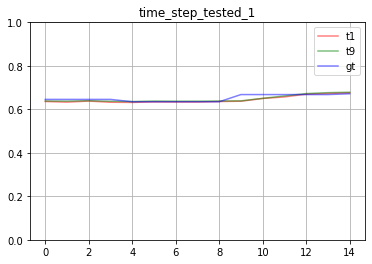

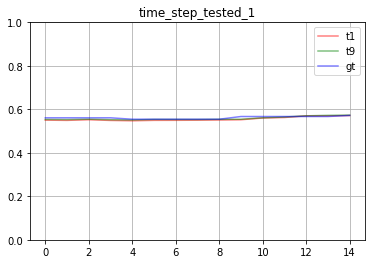

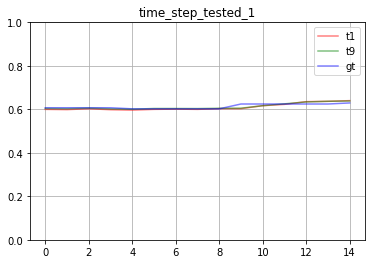

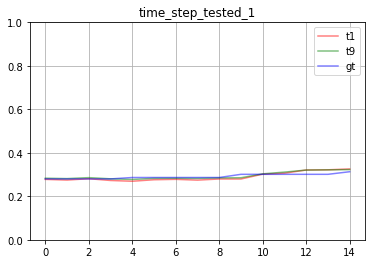

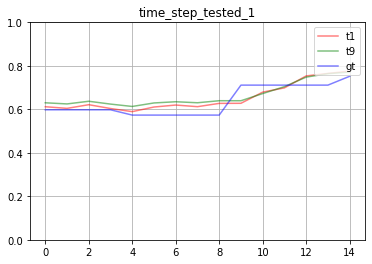

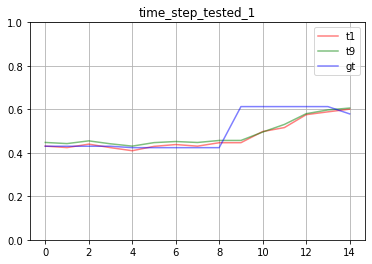

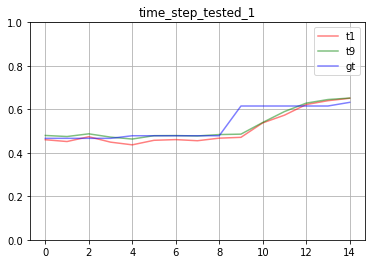

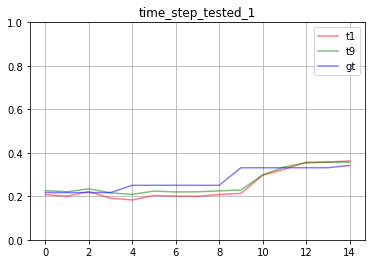

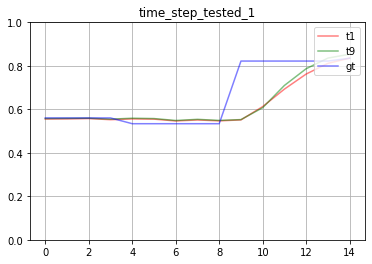

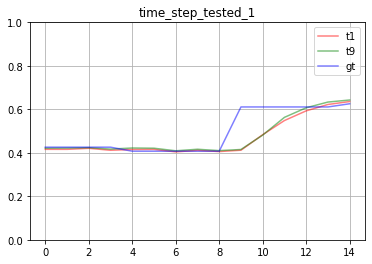

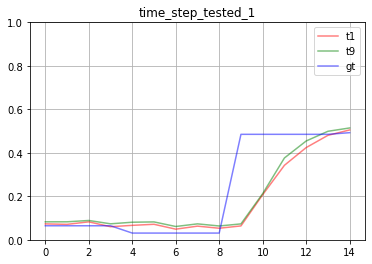

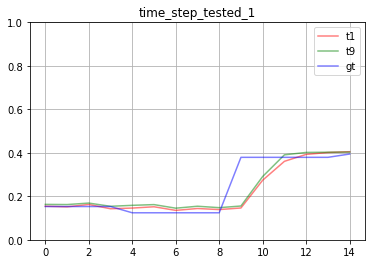

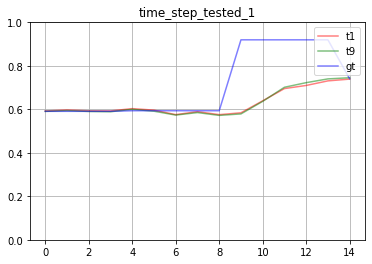

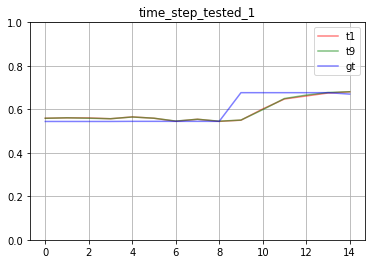

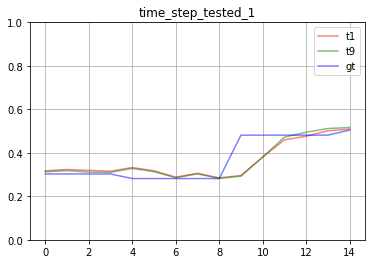

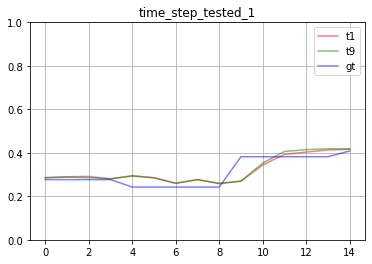

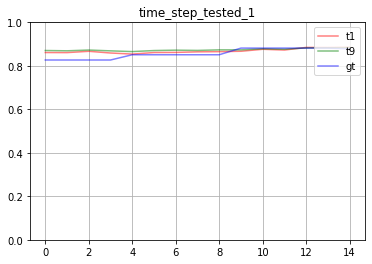

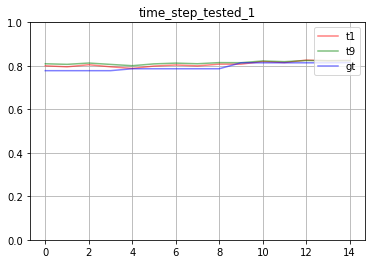

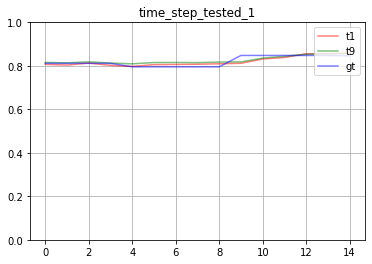

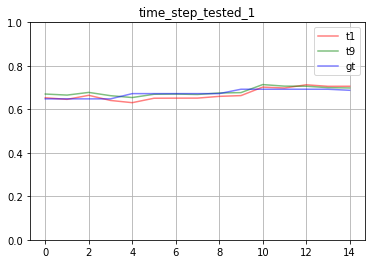

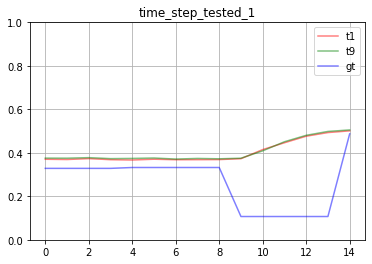

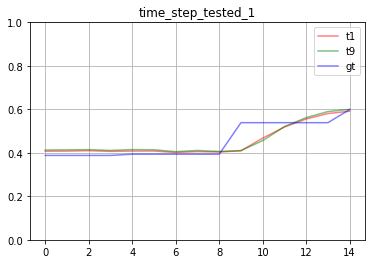

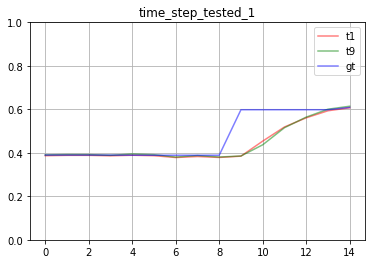

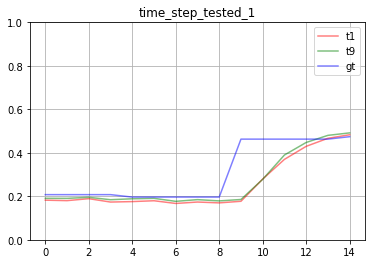

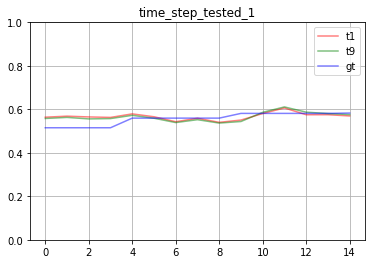

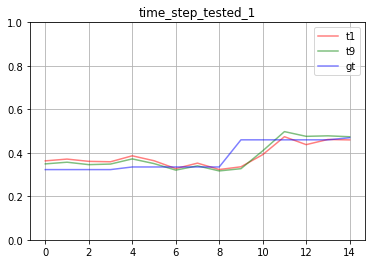

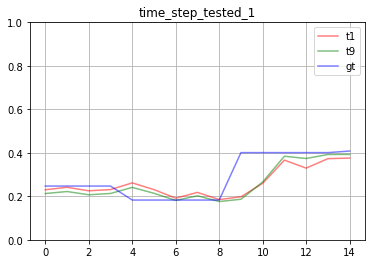

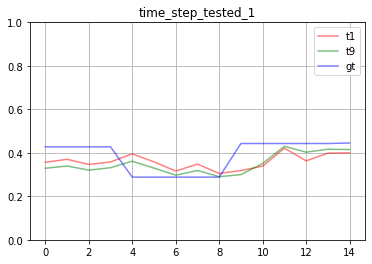

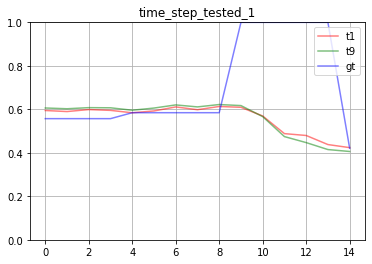

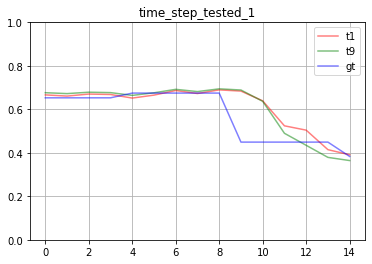

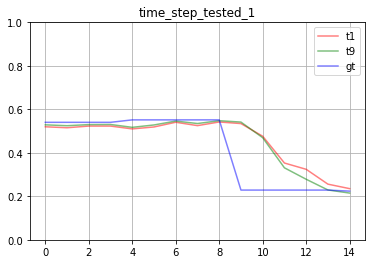

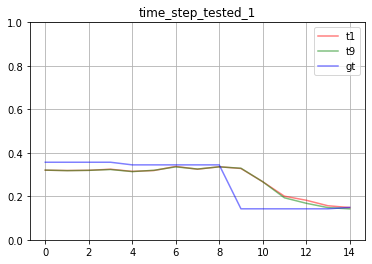

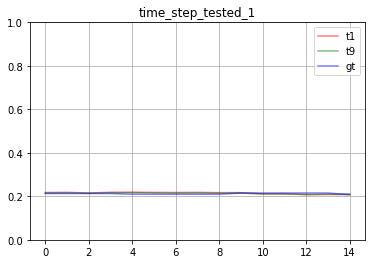

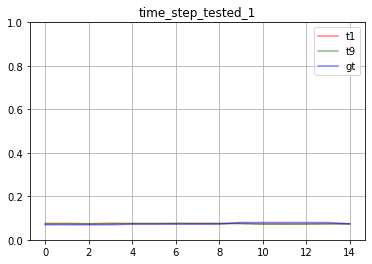

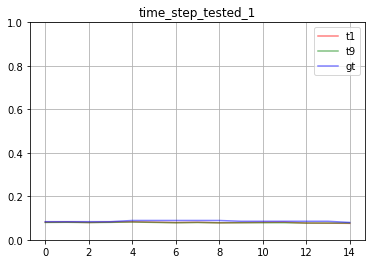

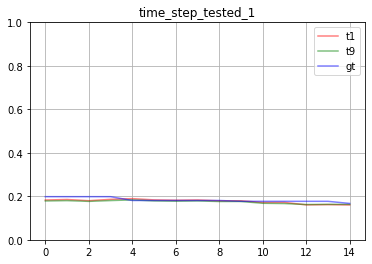

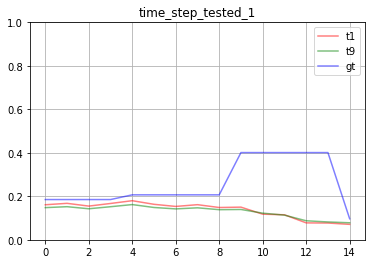

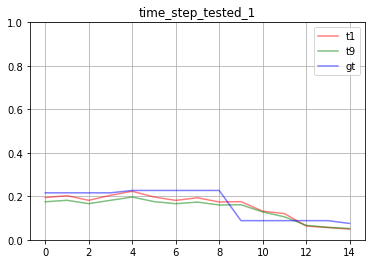

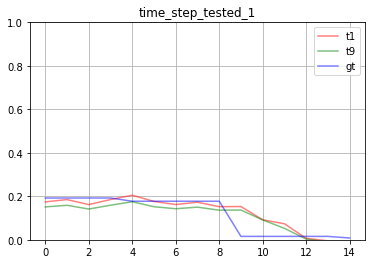

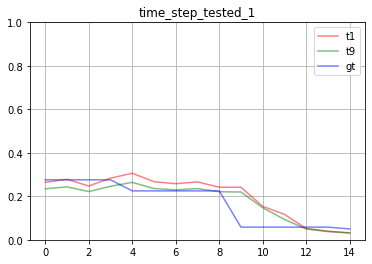

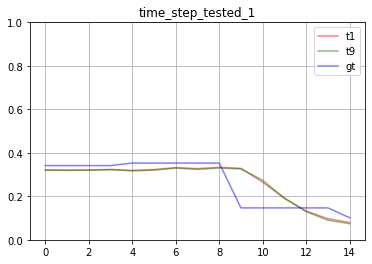

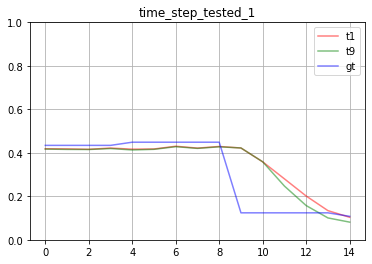

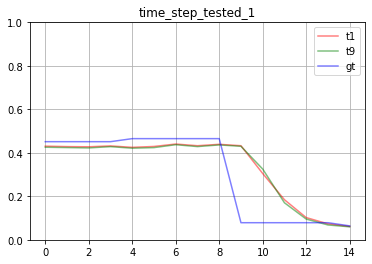

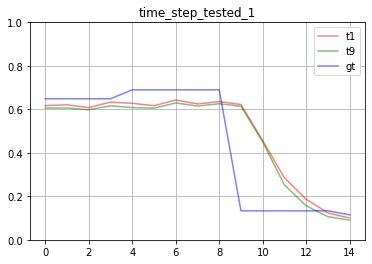

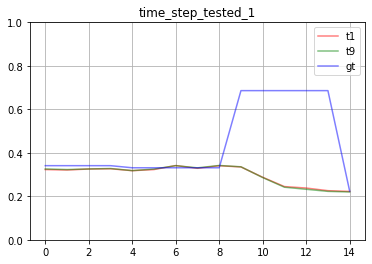

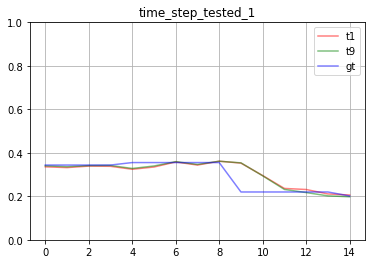

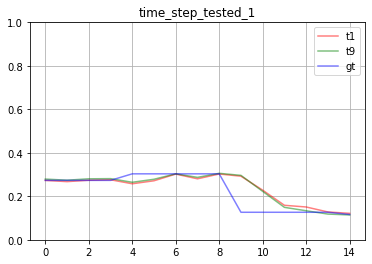

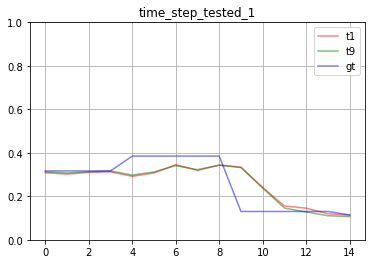

In [144]:
# test data
index = 0
titles = ["sheerx", "sheery", "normal"]
for j in range(3):
    for i in range(16):
        groundtruth_taxle = []
        predicted_taxel = []
        predicted_taxel_t1 = []
        predicted_taxel_t9 = []
        for k in range(len(predicted_data_t9)):  # add in length of context data
#             data = groundtruth_data[k].cpu().detach().numpy()
#             data = data.reshape(int(len(data)/3), 3)
#             groundtruth_taxle.append(data.T.flatten()[index])

#             data = predicted_data[k].cpu().detach().numpy()
#             data = data.reshape(int(len(data)/3), 3)
#             predicted_taxel.append(data.T.flatten()[index])

            data = groundtruth_data[k].cpu().detach().numpy()
            data = data.reshape(int(len(data)/3), 3)
            groundtruth_taxle.append(data.T.flatten()[index])
            data = predicted_data_t1[k].cpu().detach().numpy()
            data = data.reshape(int(len(data)/3), 3)
            predicted_taxel_t1.append(data.T.flatten()[index])
            data = predicted_data_t9[k].cpu().detach().numpy()
            data = data.reshape(int(len(data)/3), 3)
            predicted_taxel_t9.append(data.T.flatten()[index])
        index += 1
#         plt.title("time_step_tested_" + str(time_step_to_test))
#         plt.plot(predicted_taxel, alpha=0.5, c="r", label="pred")
#         plt.plot(groundtruth_taxle, alpha=0.5, c="g", label="gt")
        plt.title("time_step_tested_" + str(time_step_to_test_t1))
        plt.plot(predicted_taxel_t1, alpha=0.5, c="r", label="t1")
        plt.plot(predicted_taxel_t9, alpha=0.5, c="g", label="t9")
        plt.plot(groundtruth_taxle, alpha=0.5, c="b", label="gt")
        plt.ylim([0, 1])
        plt.grid()
        plt.legend(loc="upper right")
#         plt.savefig('/home/user/Robotics/slip_detection_model/images/test_6/simple_model_test_sample_' + str(index) + '.png')
        plt.show()
